In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import ecco_v4_py as ecco
import requests
import gc
import numpy as np
import pandas as pd

In [2]:
from dask.distributed import Client

client = Client()
client.run(gc.collect)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 15.61 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56469,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 15.61 GiB
Comm: tcp://127.0.0.1:56496,Total threads: 3
Dashboard: http://127.0.0.1:56498/status,Memory: 3.90 GiB
Nanny: tcp://127.0.0.1:56473,


In [3]:
ecco_dir_ = 'D:/ECCOv4_heat_transport'
otrans_ = 'ocean_transport_terms'

tr_fs_ = [f'{ecco_dir_}/{otrans_}/{f}' for f in os.listdir(f'{ecco_dir_}/{otrans_}') if '.nc' in f]

In [4]:
aggregate_yearly = True
year_at_a_time = '2013'

### Bodge and aggregate - transport terms

In [6]:
def add_time(ds):
    
    units, ref_date = ds.time.attrs['units'].split('since')
    
    ds['time'] = pd.date_range(start=ref_date, periods=ds.sizes['time'],
                               freq='D'
    )
    
    return ds

In [7]:
# aggregating datasets
years = ['2012','2013','2014','2015','2016','2017']

years_subs_={}
for y in years:
    yr_ls_ = [f for f in tr_fs_ if y in f]
    
    #print(len(yr_ls_), '',sep='\n')
    
    years_subs_[y] = yr_ls_


In [8]:
# %%time

# if aggregate_yearly:

#     ds_ = add_time(xr.open_mfdataset(years_subs_[year_at_a_time],
#                    decode_cf=False,
#                    chunks={'time':30}
#                    )
#     )
    

In [9]:
%%time
ds_ = xr.open_mfdataset(years_subs_[year_at_a_time],
                           chunks={'time':30}
)
ds_

CPU times: total: 1min 48s
Wall time: 3min 20s


<xarray.Dataset>
Dimensions:    (i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_u: 50, k_l: 50, k_p1: 51, tile: 13, time: 365, nv: 2, nb: 4)
Coordinates: (12/22)
  * i          (i) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k          (k) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_u        (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
    ...         ...
    Zu         (k_u) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    Zl         (k_l) float32 dask.array<chunksize=(50,), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    Z_bnds     (k, nv) float32 dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    ADVx_TH    (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFxE_TH    (time, k, tile, j, i_g) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVy_TH    (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFyE_TH    (time, k, tile, j_g, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    ADVr_TH    (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrE_TH    (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
    DFrI_TH    (time, k_l, tile, j, i) float32 dask.array<chunksize=(1, 50, 13, 90, 90), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1D
    time_coverage_end:               2013-01-02T00:00:00
    time_coverage_resolution:        P1D
    time_coverage_start:             2013-01-01T00:00:00
    title:                           ECCO Ocean Three-Dimensional Potential T...
    uuid:                            ca206cea-4162-11eb-960a-0cc47a3f4701

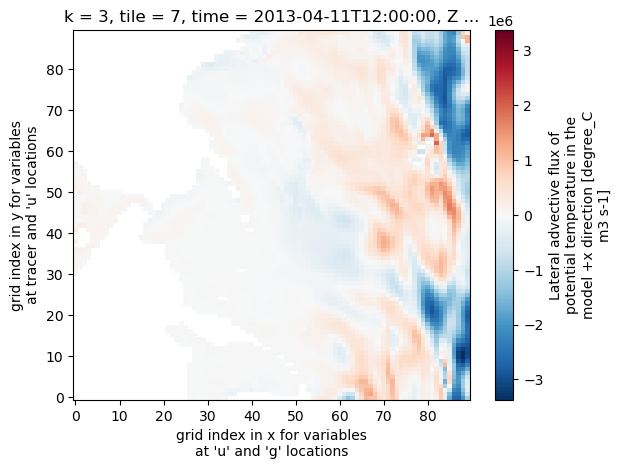

In [10]:
ds_.ADVx_TH.isel(tile=7, k=3, time=100).plot()

### Interpolate to regular grid

In [24]:
import xgcm

In [25]:
# get the useful grid
grid = xr.open_dataset('./grid_dir/mitgcm_grid.nc').rename({'face':'tile'}
                                                          ).squeeze(drop=True)

In [26]:
# Make the XGCM object
xgcm_grid = ecco.get_llc_grid(test_ds)

# look at the XGCM object.
xgcm_grid

<xgcm.Grid>
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * right    k_u --> center
  * left     k_l --> center
  * outer    k_p1 --> center
T Axis (not periodic, boundary=None):
  * center   time
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center

In [27]:
xfld = test_ds.ADVx_TH.isel(time=0)
yfld = test_ds.ADVy_TH.isel(time=0)

flux = xgcm_grid.interp_2d_vector({'X': xfld, 'Y': yfld}, boundary='fill')

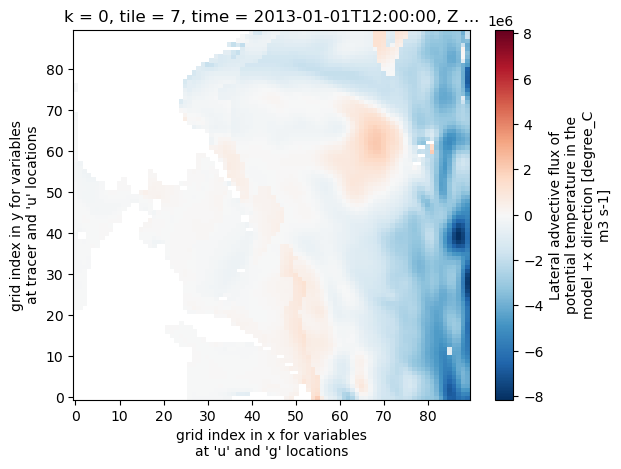

In [28]:
xfld.isel(tile=7, k=0).plot()

In [29]:
flux['Y'].dims

('k', 'tile', 'j', 'i')

In [30]:
oflux_E  = flux['X']*grid['CS'] - flux['Y']*grid['SN']
oflux_N  = flux['X']*grid['SN'] + flux['Y']*grid['CS']

(<Figure size 900x900 with 25 Axes>,
 array([[nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        [nan, nan, nan, ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]))

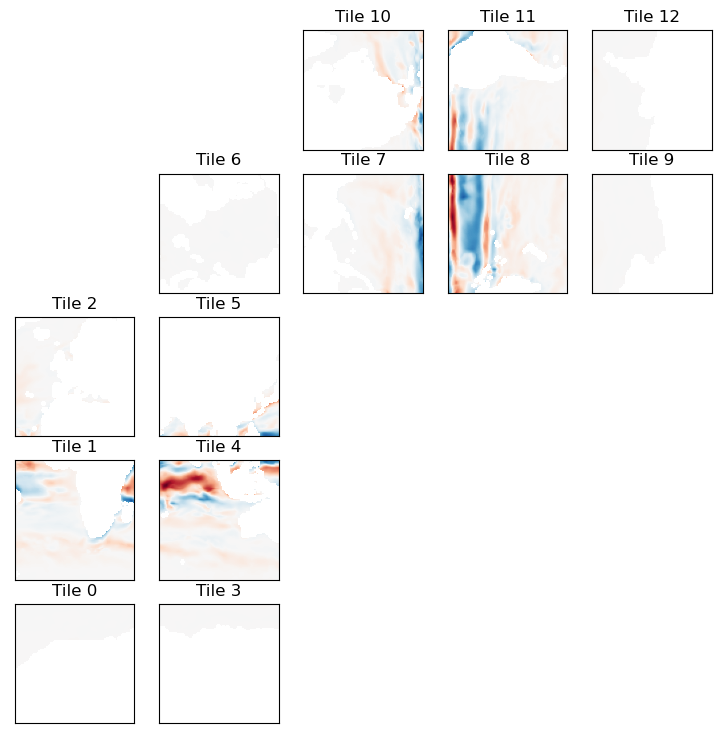

In [77]:
# test plot
oflux_E_masked = np.where(grid.maskC.isel(k=3)>0, oflux_E.isel(k=3), np.nan)
ecco.plot_tiles(oflux_E_masked)

In [34]:
oflux_E

,Array,Chunk
Bytes,20.08 MiB,1.51 MiB
Shape,"(50, 13, 90, 90)","(50, 1, 89, 89)"
Count,3033 Tasks,52 Chunks
Type,float32,numpy.ndarray


In [73]:
# help(ecco.resample_to_latlon)

In [70]:
new_grid_delta_lat = .5
new_grid_delta_lon = .5

# new_grid_min_lat = (-90+new_grid_delta_lat)/2
# new_grid_max_lat = (90-new_grid_delta_lat)/2

# new_grid_min_lon = (-180+new_grid_delta_lon)/2
# new_grid_max_lon = (180-new_grid_delta_lon)/2

#new_grid_lon, new_grid_lat, oflux_E_masked_latlon = 
a = ecco.resample_to_latlon(
                        test_ds.XC, 
                        test_ds.YC, 
                        oflux_E.isel(k=3),
                        -90, 90, new_grid_delta_lat,
                        -180, 180, new_grid_delta_lon,
                        fill_value = np.NaN, 
                        mapping_method = 'nearest_neighbor',
                        radius_of_influence = 120000
)

# plot the whole field, this time land values are nans.
plt.figure(figsize=(12,8), dpi= 90)
plt.imshow(a[4], origin='lower', cmap='coolwarm')
plt.title('Help...')
plt.colorbar(orientation='horizontal')

-179.75 179.75
-180.0 180.0
-89.75 89.75
-90.0 90.0


In [57]:
# %%time

# save_dir_ = f'{ecco_dir_}/ocean_transport_terms_aggr/'

# if aggregate_yearly:
    
#     vars_ = ['ADVx_TH','DFxE_TH','ADVy_TH','DFyE_TH','ADVr_TH','DFrE_TH','DFrI_TH']

#     for v in vars_[6:7]:
    
#         new_ds = ds_[v].load()
#         new_ds.to_netcdf(save_dir_+f'{v}_{year_at_a_time}.nc')
        
#         new_ds.close()
#         del new_ds
        
#         print(v, '', sep='\n')


### Test the aggregations

In [53]:
# import cartopy.crs as crs
# import numpy as np
#import warnings
#warnings.filterwarnings('ignore')

In [56]:
# get grid
# os.listdir('./grid_dir')

In [55]:
# grid = xr.open_dataset('./grid_dir/mitgcm_grid.nc')

In [55]:
# test_fs = [save_dir_+f for f in os.listdir(save_dir_)]
# test_fs

In [51]:
# %%time
# test_read = xr.open_mfdataset(test_fs, chunks={'time':30})

# test_read

In [52]:
# pnt_lat, pnt_lon = np.array([60, 20]), np.array([-140, -140])

In [53]:
# field = test_read.ADVy_TH.isel(time=100, k=3,).load()

In [54]:
# test plot, seems the grid info is actually in the files, which is nice

# fig  = plt.figure(figsize=(16,7))

# ecco.plot_proj_to_latlon_grid(grid.XC, grid.YC, 
#                                   field,
#                                   user_lon_0=-140,
#                                   dx=0.25,
#                                   dy=0.25,
#                                   show_colorbar=True,
# )

# plt.title('testing testing...')
# plt.show()


### Clean up nb

In [11]:
client.shutdown()